In [11]:
# Import statements
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pathlib import Path
from MCForecastTools import MCSimulation
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
from dotenv import load_dotenv

In [23]:
# Read in cleaned house price data
file_name='house_price_df.csv'
csv_file=Path(f"../Data/Clean/{file_name}")
house_price_df= pd.read_csv(csv_file)

# Organize cleaned data for Monte Carlo Simulation
house_price_df.set_index(house_price_df['Date'],inplace=True) # Set index as Date
house_price_df.columns = [house_price_df.columns,['Ticker'] * len(house_price_df.columns), ['close'] * len(house_price_df.columns)] # Add header rows for prebuilt Monte Carlo code
house_price_df.drop(columns=['Date','United States'],inplace=True) # Drop unnecessary columns

# Show final dataframe
house_price_df.head()

,"New York, NY","Los Angeles, CA","Chicago, IL","Dallas, TX","Philadelphia, PA","Houston, TX","Washington, DC","Miami, FL","Atlanta, GA","Boston, MA",...,"Winnemucca, NV","Sweetwater, TX","Andrews, TX","Zapata, TX","Vermillion, SD","Lamesa, TX","Craig, CO","Pecos, TX","Vernon, TX","Ketchikan, AK"
,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,...,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker,Ticker
,close,close,close,close,close,close,close,close,close,close,...,close,close,close,close,close,close,close,close,close,close
Date,,,,,,,,,,,,,,,,,,,,,
1/31/1996,187842.0,183929.0,164647.0,114406.0,121233.0,110773.0,178034.0,109403.0,120291.0,168008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,60501.0,NaN,NaN,NaN
2/29/1996,187403.0,184185.0,164345.0,114471.0,121078.0,110849.0,177811.0,109533.0,120519.0,168003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,60725.0,NaN,NaN,NaN
3/31/1996,187125.0,184205.0,163946.0,114634.0,120937.0,110858.0,177681.0,109670.0,120740.0,168176.0,...,NaN,NaN,NaN,NaN,NaN,NaN,60961.0,NaN,NaN,NaN
4/30/1996,186592.0,184312.0,163493.0,114962.0,120693.0,111007.0,177407.0,109917.0,121229.0,168453.0,...,NaN,NaN,NaN,NaN,NaN,NaN,61420.0,NaN,NaN,NaN
5/31/1996,186274.0,184286.0,162886.0,115314.0,120527.0,111148.0,177288.0,110132.0,121711.0,168821.0,...,NaN,NaN,NaN,NaN,NaN,NaN,61747.0,NaN,NaN,NaN


In [24]:
# read the uscities csv. this file will be used for the longitude and latitude, as well as the density stats.
longlatdensity_csv = Path("../Data/uscities.csv")
longlatdensity_df = pd.read_csv(longlatdensity_csv)

#getting first zipcode from list of zipcodes
longlatdensity_df[['firstzip']] = longlatdensity_df['zips'].str.split(",", n = 1, expand=True)
longlatdensity_df[['firstzip']] = longlatdensity_df['zips'].str[:5]

#dropping unnecessary columns
longlatdensity_df.drop(columns=['source','military','incorporated','timezone','city_ascii',"zips"],inplace=True)
longlatdensity_df.drop_duplicates()
longlatdensity_df.head()

,city,state_id,state_name,county_fips,county_name,lat,lng,population,density,ranking,id,firstzip
0,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220.0,10715.0,1,1840034016,11229
1,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807.0,3276.0,1,1840020491,90291
2,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203.0,4574.0,1,1840000494,60018
3,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545.0,5019.0,1,1840015149,33129
4,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938.0,1526.0,1,1840019440,75287


In [ ]:
# Configuring a Monte Carlo simulation to forecast housing market returns
# Create dataframe to store outputs
returns = pd.DataFrame(index=['1 Year Avg Return', '3 Year Avg Return', '5 Year Avg Return'])

# For loop to run through every MSA in dataset
for msa in house_price_df.columns.get_level_values(0):

    MC = MCSimulation(
        portfolio_data = house_price_df[msa],
        weights = [1],
        num_simulation = 1000,
        num_trading_days = 12*5
    )

    # Running a Monte Carlo simulation to forecast cumulative returns
    sim_df = MC.calc_cumulative_return() - 1
    returns.loc['5 Year Avg Return',msa] = ((1 + sim_df.iloc[-1,:].mean()) ** (1/5)) - 1 
    returns.loc['3 Year Avg Return',msa] = ((1 + sim_df.iloc[35,:].mean()) ** (1/3)) - 1
    returns.loc['1 Year Avg Return',msa] = ((1 + sim_df.iloc[11,:].mean()) ** (1/1)) - 1

In [42]:
# Sort values and reformat table
house_price_forecast = returns.sort_values(by='5 Year Avg Return', axis=1,ascending=False)
house_price_forecast = house_price_forecast.transpose()
house_price_forecast

,1 Year Avg Return,3 Year Avg Return,5 Year Avg Return
"Pecos, TX",0.102517,0.109088,0.112390
"Grenada, MS",0.090191,0.096231,0.098996
"Winnemucca, NV",0.079808,0.085549,0.088096
"Williston, ND",0.069708,0.074843,0.076888
"Klamath Falls, OR",0.066540,0.070972,0.073121
...,...,...,...
"Decatur, IL",-0.002301,-0.001799,-0.001862
"Espa±ola, NM",-0.006707,-0.007444,-0.007541
"Deming, NM",-0.014710,-0.015592,-0.015886
"Cambridge, MD",-0.018200,-0.019024,-0.019406


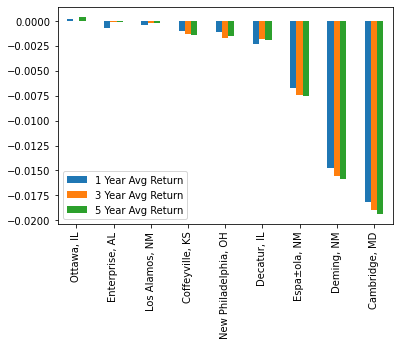

In [43]:
# Sample plot of data
plot_data = house_price_forecast.iloc[-10:-1,:]
plot_data.plot(kind='bar')

In [44]:
# Reformat table for joining with coordinates data
house_price_forecast.reset_index(inplace=True)
house_price_forecast[['city','state']] = house_price_forecast['index'].str.split(", ", n = 1, expand=True)
house_price_forecast.drop(columns=['index'],inplace=True)
house_price_forecast.set_index(['city','state'],inplace=True)
house_price_forecast

,,1 Year Avg Return,3 Year Avg Return,5 Year Avg Return
city,state,,,
Pecos,TX,0.102517,0.109088,0.112390
Grenada,MS,0.090191,0.096231,0.098996
Winnemucca,NV,0.079808,0.085549,0.088096
Williston,ND,0.069708,0.074843,0.076888
Klamath Falls,OR,0.066540,0.070972,0.073121
...,...,...,...,...
Decatur,IL,-0.002301,-0.001799,-0.001862
Espa±ola,NM,-0.006707,-0.007444,-0.007541
Deming,NM,-0.014710,-0.015592,-0.015886


In [48]:
# Join coordinates data with forecasted prices for final dataframe
coordinates_df = longlatdensity_df.loc[:,['city','lat','lng','population','firstzip','state_id']] 
coordinates_df.drop_duplicates(subset=['city','state_id'],inplace=True)
coordinates_df.set_index(['city','state_id'],inplace=True)
combined_forecast_df = pd.concat([house_price_forecast,coordinates_df], axis='columns', join='inner')
combined_forecast_df.head()

,,1 Year Avg Return,3 Year Avg Return,5 Year Avg Return,lat,lng,population,firstzip
Albany,GA,0.020838,0.021972,0.022676,31.5776,-84.1762,89217.0,31721
Forrest City,AR,0.012267,0.012868,0.013272,35.0135,-90.7931,12309.0,72322
Hannibal,MO,0.022298,0.023627,0.024375,39.7097,-91.3939,17884.0,63401
Shelton,WA,0.052263,0.055535,0.056912,47.2186,-123.1120,20264.0,98584
Hereford,TX,0.049562,0.052332,0.054101,34.8232,-102.4001,15164.0,79045


In [49]:
# Output montecarlo simulation end product
mc_output_csv = Path("../Data/mc_output.csv")
combined_forecast_df.to_csv(mc_output_csv)

In [68]:
# Read the montecarlo data csv
mc_output_csv = Path("../Data/mc_output.csv")
mc_output = pd.read_csv(mc_output_csv)
mc_output[['1 Year Avg Return','3 Year Avg Return','5 Year Avg Return']] = mc_output[['1 Year Avg Return','3 Year Avg Return','5 Year Avg Return']]*100

In [69]:
mc_output.head()

,Unnamed: 0,Unnamed: 1,1 Year Avg Return,3 Year Avg Return,5 Year Avg Return,lat,lng,population,firstzip
0,Cullman,AL,2.973927,3.206215,3.307670,34.1777,-86.8407,19920.0,35058
1,Gallup,NM,0.383775,0.425795,0.445561,35.5183,-108.7423,22917.0,87301
2,Niles,MI,2.345951,2.540427,2.632331,41.8346,-86.2473,11149.0,49120
3,Dodge City,KS,1.878296,2.016130,2.085382,37.7610,-100.0183,27080.0,67801
4,Coffeyville,KS,-0.247255,-0.181866,-0.161729,37.0518,-95.6180,9827.0,67337


In [78]:
# Formatting final data table for monte carlo statistical summary
higher_pop_output = mc_output.loc[mc_output['population'] > 50000]
mc_analysis = higher_pop_output.describe()
mc_analysis.drop(columns=['lat','lng','firstzip'],inplace=True)
mc_analysis.style.format({"1 Year Avg Return": "{:.2f}", 
                          "3 Year Avg Return": "{:.2f}", 
                          "5 Year Avg Return": "{:.2f}",
                          "population":"{:20,.0f}"})

,1 Year Avg Return,3 Year Avg Return,5 Year Avg Return,population
count,353.00,353.00,353.00,353
mean,2.84,3.01,3.09,"521,585"
std,1.07,1.13,1.16,"1,359,038"
min,-0.23,-0.20,-0.20,"50,408"
25%,2.19,2.31,2.39,"77,609"
50%,2.74,2.95,3.05,"142,847"
75%,3.48,3.67,3.77,"378,732"
max,6.22,6.65,6.87,"18,713,220"
